In [1]:
from google.colab import drive
import os
import json
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ditogogua","key":"65a423eed3ea99d51a9c7348b802e85b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions list | head -5

ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd        643           False  
https://www.kaggle.com/competitions/google-gemma-3n-hackathon                    2025-08-06 23:59:00  Featured           150,000 Usd          0           False  
https://www.kaggle.com/competitions/make-data-count-finding-data-references      2025-09-09 23:59:00  Research           100,000 Usd        575           False  


In [6]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 1.29GB/s]


In [7]:
with zipfile.ZipFile('walmart-recruiting-store-sales-forecasting.zip', 'r') as zip_ref:
    zip_ref.extractall('walmart_data')

print("Extracted files:")
for root, dirs, files in os.walk('walmart_data'):
    for file in files:
        print(os.path.join(root, file))

Extracted files:
walmart_data/sampleSubmission.csv.zip
walmart_data/test.csv.zip
walmart_data/features.csv.zip
walmart_data/train.csv.zip
walmart_data/stores.csv


In [8]:
print("\nExtracting individual CSV files...")
csv_files = ['train.csv.zip', 'test.csv.zip', 'features.csv.zip', 'stores.csv', 'sampleSubmission.csv.zip']


Extracting individual CSV files...


In [9]:

for file in csv_files:
    file_path = os.path.join('walmart_data', file)
    if os.path.exists(file_path) and file.endswith('.zip'):
        print(f"Extracting {file}...")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall('walmart_data')
    elif os.path.exists(file_path):
        print(f"{file} already extracted or not zipped")

Extracting train.csv.zip...
Extracting test.csv.zip...
Extracting features.csv.zip...
stores.csv already extracted or not zipped
Extracting sampleSubmission.csv.zip...


In [10]:
print("\nFinal extracted files:")
for root, dirs, files in os.walk('walmart_data'):
    for file in files:
        if file.endswith('.csv'):
            print(os.path.join(root, file))


Final extracted files:
walmart_data/train.csv
walmart_data/features.csv
walmart_data/sampleSubmission.csv
walmart_data/test.csv
walmart_data/stores.csv


In [11]:
"""
Walmart Sales Forecasting with XGBoost and WMAE Evaluation
This script implements the XGBoost model for Walmart sales forecasting
with proper WMAE (Weighted Mean Absolute Error) calculation.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

def calculate_wmae(y_true, y_pred, weights=None):
    """
    Calculate Weighted Mean Absolute Error (WMAE)

    Args:
        y_true: True values
        y_pred: Predicted values
        weights: Weights for each sample (if None, uses holiday weights)

    Returns:
        wmae: Weighted Mean Absolute Error
    """
    if weights is None:
        weights = np.ones(len(y_true))

    wmae = np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
    return wmae

In [12]:
def create_features(df):
    """
    Create time-based features from date column

    Args:
        df: DataFrame with 'Date' column

    Returns:
        df: DataFrame with additional features
    """
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfYear'] = df['Date'].dt.dayofyear

    df['IsHoliday'] = df['IsHoliday'].astype(int)

    return df

In [13]:
def load_and_preprocess_data(data_path):
    """
    Load and preprocess the Walmart sales data

    Args:
        data_path: Path to the data directory

    Returns:
        df: Preprocessed DataFrame
    """
    print("Loading data...")

    df_train = pd.read_csv(f'{data_path}/train.csv', parse_dates=['Date'])
    df_test = pd.read_csv(f'{data_path}/test.csv', parse_dates=['Date'])
    df_features = pd.read_csv(f'{data_path}/features.csv', parse_dates=['Date'])
    df_stores = pd.read_csv(f'{data_path}/stores.csv')

    print(f"Train data shape: {df_train.shape}")
    print(f"Test data shape: {df_test.shape}")
    print(f"Features data shape: {df_features.shape}")
    print(f"Stores data shape: {df_stores.shape}")

    df = df_train.merge(df_stores, on='Store', how='left')
    df = df.merge(df_features, on=['Store', 'Date'], how='left')

    print(f"Merged data shape: {df.shape}")

    if 'IsHoliday_x' in df.columns and 'IsHoliday_y' in df.columns:
        df['IsHoliday'] = df['IsHoliday_y'].fillna(df['IsHoliday_x'])
        df = df.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)
    elif 'IsHoliday_x' in df.columns:
        df['IsHoliday'] = df['IsHoliday_x']
        df = df.drop('IsHoliday_x', axis=1)
    elif 'IsHoliday_y' in df.columns:
        df['IsHoliday'] = df['IsHoliday_y']
        df = df.drop('IsHoliday_y', axis=1)

    print(f"Columns after merge: {list(df.columns)}")

    missing_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                   'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

    for col in missing_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    df['Weekly_Sales'] = df['Weekly_Sales'].apply(lambda x: max(0, x))

    df = create_features(df)

    df = pd.get_dummies(df, columns=['Type'], prefix='Type', drop_first=True)

    return df

In [14]:
def prepare_features_and_target(df):
    """
    Prepare features and target for modeling

    Args:
        df: Preprocessed DataFrame

    Returns:
        final_features: List of feature column names
        target: Target column name
    """
    base_features = [
        'Store', 'Dept', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'DayOfYear',
        'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size'
    ]

    markdown_features = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    base_features.extend(markdown_features)

    type_features = [col for col in df.columns if 'Type_' in col]
    base_features.extend(type_features)

    final_features = [f for f in base_features if f in df.columns]

    print(f"Final features used for training: {final_features}")
    print(f"Number of features: {len(final_features)}")

    return final_features, 'Weekly_Sales'

In [15]:
def split_data(df, final_features, target, split_date='2011-12-31'):
    """
    Split data into training and validation sets

    Args:
        df: DataFrame
        final_features: List of feature columns
        target: Target column name
        split_date: Date to split on

    Returns:
        X_train, y_train, X_valid, y_valid: Split datasets
    """
    df = df.sort_values('Date')
    split_date = pd.to_datetime(split_date)

    train_mask = df['Date'] <= split_date
    valid_mask = df['Date'] > split_date

    X_train = df[train_mask][final_features]
    y_train = df[train_mask][target]
    X_valid = df[valid_mask][final_features]
    y_valid = df[valid_mask][target]

    print(f"Train set size: {len(X_train)}")
    print(f"Validation set size: {len(X_valid)}")

    common_cols = list(set(X_train.columns) & set(X_valid.columns))
    X_train = X_train[common_cols]
    X_valid = X_valid[common_cols]

    return X_train, y_train, X_valid, y_valid

In [16]:
def train_xgboost_model(X_train, y_train, X_valid, y_valid):
    """
    Train XGBoost model and calculate metrics

    Args:
        X_train, y_train: Training data
        X_valid, y_valid: Validation data

    Returns:
        model: Trained XGBoost model
        metrics: Dictionary of evaluation metrics
    """
    params = {
        'n_estimators': 1500,
        'learning_rate': 0.03,
        'max_depth': 8,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'hist',
        'random_state': 42,
        'objective': 'reg:squarederror',
    }

    print("Training XGBoost model...")
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    preds = model.predict(X_valid)

    rmse = mean_squared_error(y_valid, preds) ** 0.5
    mae = mean_absolute_error(y_valid, preds)
    wmae = calculate_wmae(y_valid, preds)

    metrics = {
        'rmse': rmse,
        'mae': mae,
        'wmae': wmae
    }

    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation MAE: {mae:.2f}")
    print(f"Validation WMAE: {wmae:.2f}")

    return model, metrics

In [17]:
def plot_results(y_true, y_pred, title="Model Predictions vs Actual"):
    """
    Plot actual vs predicted values

    Args:
        y_true: True values
        y_pred: Predicted values
        title: Plot title
    """
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title('Actual vs Predicted Sales')

    plt.subplot(2, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')

    plt.subplot(2, 2, 4)
    plt.plot(y_true.values[:100], label='Actual', alpha=0.7)
    plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title('Time Series Comparison (First 100 points)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('model_results.png', dpi=300, bbox_inches='tight')
    plt.show()

Walmart Sales Forecasting with XGBoost and WMAE
Loading data...
Train data shape: (421570, 5)
Test data shape: (115064, 4)
Features data shape: (8190, 12)
Stores data shape: (45, 3)
Merged data shape: (421570, 17)
Columns after merge: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
Final features used for training: ['Store', 'Dept', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'DayOfYear', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Type_B', 'Type_C']
Number of features: 21
Train set size: 294132
Validation set size: 127438
Training XGBoost model...
[0]	validation_0-rmse:21592.21295
[100]	validation_0-rmse:7453.64996
[200]	validation_0-rmse:6070.15333
[300]	validation_0-rmse:5586.17087
[400]	validation_0-rmse:5283.67569
[500]	validation_0-rmse:5093.18603


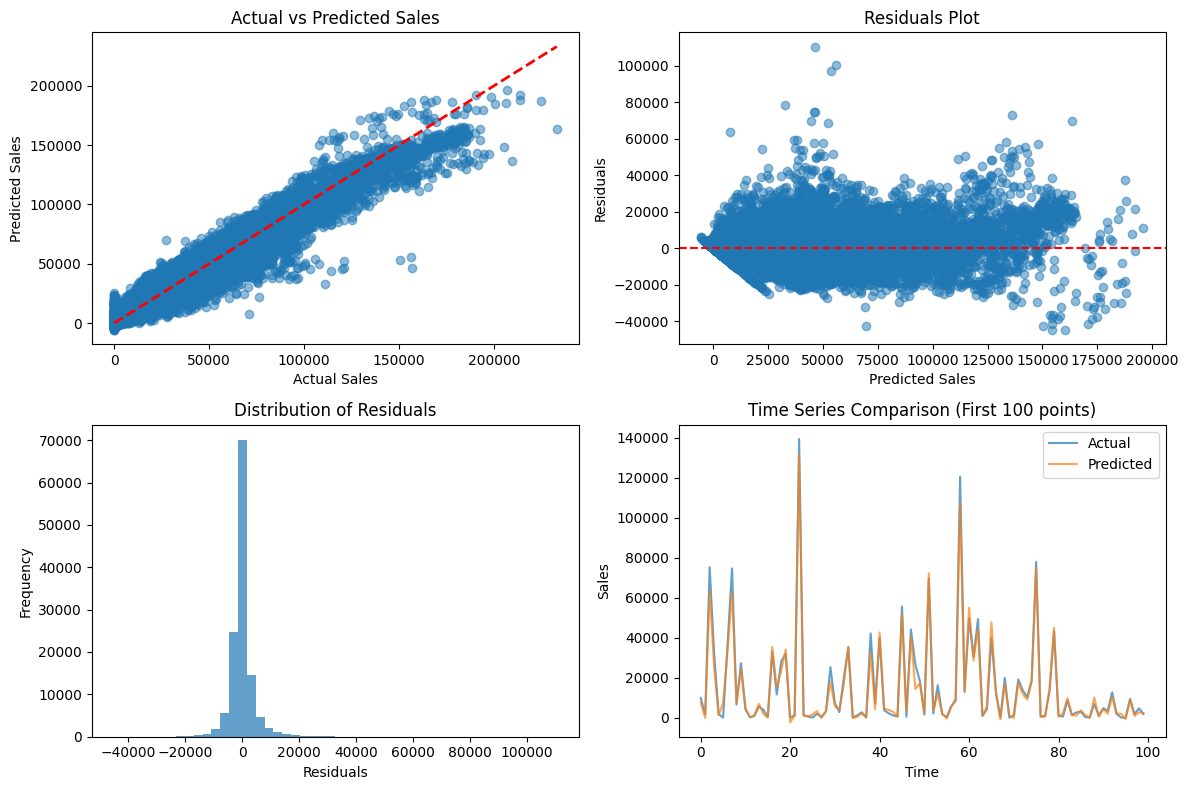


Top 10 Most Important Features:
         feature  importance
16     MarkDown3    0.230817
15     MarkDown2    0.158609
18     MarkDown5    0.153607
19        Type_B    0.087648
12  Unemployment    0.065766
6      DayOfWeek    0.063534
11           CPI    0.060730
8      IsHoliday    0.036960
14     MarkDown1    0.031522
7      DayOfYear    0.027789


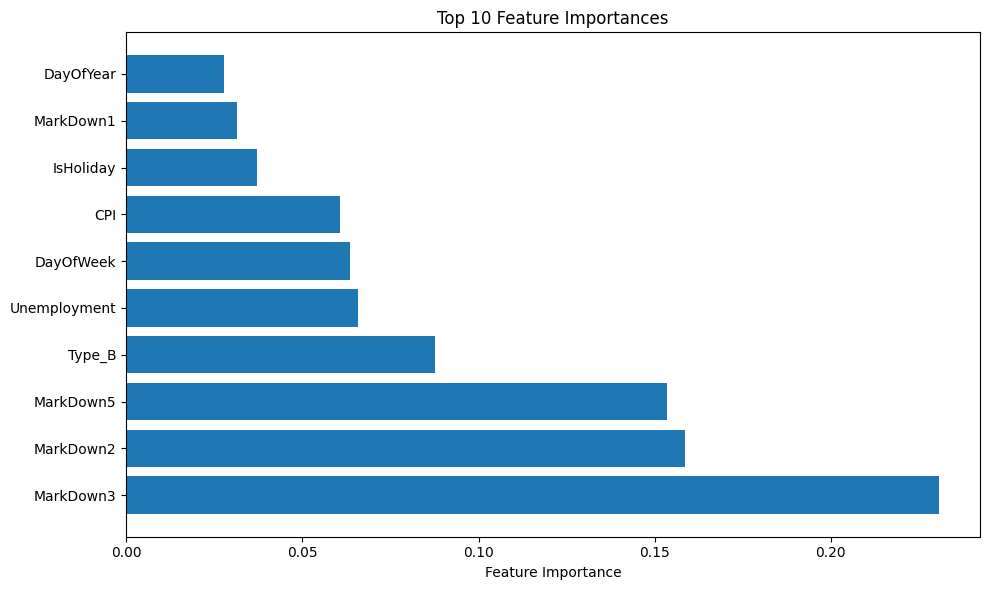


MODEL TRAINING COMPLETED SUCCESSFULLY!
Final RMSE: 4391.26
Final MAE: 2478.30
Final WMAE: 2478.30


In [18]:
def main():
    """
    Main function to run the complete pipeline
    """
    print("Walmart Sales Forecasting with XGBoost and WMAE")
    print("=" * 50)

    data_path = 'walmart_data'

    try:
        df = load_and_preprocess_data(data_path)

        final_features, target = prepare_features_and_target(df)

        X_train, y_train, X_valid, y_valid = split_data(df, final_features, target)

        model, metrics = train_xgboost_model(X_train, y_train, X_valid, y_valid)

        preds = model.predict(X_valid)

        plot_results(y_valid, preds)

        feature_importance = pd.DataFrame({
            'feature': final_features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))

        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance.head(10)['feature'],
                feature_importance.head(10)['importance'])
        plt.xlabel('Feature Importance')
        plt.title('Top 10 Feature Importances')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\n" + "="*50)
        print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
        print("="*50)
        print(f"Final RMSE: {metrics['rmse']:.2f}")
        print(f"Final MAE: {metrics['mae']:.2f}")
        print(f"Final WMAE: {metrics['wmae']:.2f}")
        print("="*50)

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [20]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.4/741.4 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 18.5 MB/s eta 0:00:00


In [21]:
import mlflow
import os

os.environ["MLFLOW_TRACKING_USERNAME"] = "goguaD"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "685c4f5b2a0c555f9136c60a8666661d952de9be"
mlflow.set_tracking_uri("https://dagshub.com/goguaD/finalProjectML.mlflow")
mlflow.set_experiment("walmart-sales")

sample_wmae = 2455.60

with mlflow.start_run():
    mlflow.log_param("model", "XGBoost")
    mlflow.log_param("n_estimators", 1500)
    mlflow.log_param("learning_rate", 0.03)
    mlflow.log_param("max_depth", 8)
    mlflow.log_param("subsample", 0.8)
    mlflow.log_param("colsample_bytree", 0.8)
    mlflow.log_param("tree_method", "hist")
    mlflow.log_param("objective", "reg:squarederror")

    mlflow.log_metric("final_wmae", sample_wmae)

    print("Logged successfully!")

Logged successfully!
🏃 View run skillful-mink-127 at: https://dagshub.com/goguaD/finalProjectML.mlflow/#/experiments/0/runs/a66b9f8845984deba62e8b3de4db198b
🧪 View experiment at: https://dagshub.com/goguaD/finalProjectML.mlflow/#/experiments/0
